In [1]:
import sys
import os

project_root = os.path.abspath(os.path.join(os.getcwd()))
sys.path.append(project_root)

from src.clients.solana.meteora import SolanaMeteoraClient
from src.utils.analyzer import Analyzer
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import matplotlib.dates as mpl_dates
import pandas as pd
from datetime import datetime, timedelta
from mplfinance.original_flavor import candlestick_ohlc

client = SolanaMeteoraClient()

Setting API URL: https://dlmm-api.meteora.ag
Setting RPC: https://api.mainnet-beta.solana.com
Creating session...
Session headers set: {'User-Agent': 'python-requests/2.32.3', 'Accept-Encoding': 'gzip, deflate', 'Accept': 'application/json', 'Connection': 'keep-alive', 'Content-type': 'application/json', 'rpc': 'https://api.mainnet-beta.solana.com'}
Initialized MoralisPriceFetcher with API key: eyJh...
Fetching token symbols from CoinGecko...
Mapped 3779 Solana token addresses to symbols


# FETCH NEW LPs DATA

In [2]:
# Fetch and filter pools
pools = client.fetch_liquidity_pools()
min_tvl = 100000
min_volume = 50000
filtered_pairs = client.filter_pairs(pools, min_tvl=min_tvl, min_volume=min_volume)
print(f"Filtered pairs (TVL >= {min_tvl}, Volume >= {min_volume}): {len(filtered_pairs)}")
for pair in filtered_pairs:
    print(pair)

Fetching pools from https://dlmm-api.meteora.ag/pair/all
Status code: 200
Total pools in response: 70284
Sample pool: {'address': 'G3YLKxdKUYgYR3Pu25JMJzt6i8fcbRbYna38DVRHFHm8', 'name': 'CATDOG-USDC', 'mint_x': 'CATTzAwLyADd2ekzVjTjX8tVUBYfrozdkJBkutJggdB7', 'mint_y': 'EPjFWdd5AufqSSqeM2qN1xzybapC8G4wEGGkZwyTDt1v', 'reserve_x': 'GZzVHw4cmDPqMJ6wMJVPJMDx8gvS2QmDmkoSgXVdPF2F', 'reserve_y': '5JqH4vLuKsmBabQUiTkhNpiJuGZtCnLAr17FqvoDJsgz', 'reserve_x_amount': 234, 'reserve_y_amount': 249, 'bin_step': 200, 'base_fee_percentage': '0.8', 'max_fee_percentage': '7.55', 'protocol_fee_percentage': '5', 'liquidity': '0.0000000009671619766261449', 'reward_mint_x': '11111111111111111111111111111111', 'reward_mint_y': '11111111111111111111111111111111', 'fees_24h': 0.0, 'today_fees': 0.0, 'trade_volume_24h': 0.0, 'cumulative_trade_volume': '2678.5400', 'cumulative_fee_volume': '39.0700', 'current_price': 0.00041332576386930833, 'apr': 0.0, 'apy': 0.0, 'farm_apr': 0.0, 'farm_apy': 0.0, 'hide': False, '

In [3]:
# Filter for native token (SOL) and utility token pairs
native_utility_pairs = client.filter_native_utility_pairs(filtered_pairs)
print(f"Native-Utility pairs found: {len(native_utility_pairs)}")
for pair in native_utility_pairs:
    print(f"Native-Utility pair: {pair.token0_symbol}-{pair.token1_symbol} (TVL: {pair.tvl})")


Native-Utility pairs found: 0


### FIND LARGEST POOL FOR EACH SELECTED TOKEN

In [4]:
# Extract unique tokens and find largest SOL or USDC pool per token
token_to_pool = {}
for token in set(p.token0_address for p in filtered_pairs).union(p.token1_address for p in filtered_pairs):
    # Prefer SOL pool, then USDC if no SOL pool exists
    sol_pool = client.get_largest_pool(token, pools, base_token=client.SOL_ADDRESS)
    usdc_pool = client.get_largest_pool(token, pools, base_token=client.USDC_ADDRESS)
    largest_pool = sol_pool if sol_pool else usdc_pool
    if largest_pool:
        ticker = f"{largest_pool.token0_symbol}"
        base = f"{largest_pool.token1_symbol}"
        token_to_pool[token] = {
            "pair_address": largest_pool.address,
            "ticker": ticker,
            "base": base,
            "tvl": largest_pool.tvl
        }

tokens = set(token_to_pool.keys())
print(f"Tokens to analyze: {len(tokens)}")
print(token_to_pool)


Tokens to analyze: 15
{'61V8vBaqAGMpgDQi4JcAwo1dmBGHsyhzodcPqnEVpump': {'pair_address': '92J3X46dbnoPs25Vc3fr5m1xt9GVrQddqiPD9uzXQHH', 'ticker': 'ARC', 'base': 'SOL', 'tvl': 693469.3491863015}, '27G8MtK7VtTcCHkpASjSDdkWWYfoqT6ggEuKidVJidD4': {'pair_address': 'J2Gsg3xTDjM8UZjKdEqzBeDwitHb2Ux6TSBX5RzsE42r', 'ticker': 'JLP', 'base': 'SOL', 'tvl': 2867962.7029787786}, '3NZ9JMVBmGAqocybic2c7LQCJScmgsAZ6vQqTDzcqmJh': {'pair_address': '4kdxjt8pKEW4qV4ji4HANixwswDJw3Egn8L4x2BEWQqT', 'ticker': 'WBTC', 'base': 'SOL', 'tvl': 241230.29651151533}, '9McvH6w97oewLmPxqQEoHUAv3u5iYMyQ9AeZZhguYf1T': {'pair_address': '6QBHzndsRpzuTxwDC2avVmQ6B291gM1sDx9oW9BfcFkE', 'ticker': 'ANON', 'base': 'SOL', 'tvl': 237000.70549362522}, 'bSo13r4TkiE4KumL71LsHTPpL2euBYLFx6h9HP3piy1': {'pair_address': '3q4KmkMmzatUwvBs15Pdn2PR1X6h8GvuoXF5T9cPejqF', 'ticker': 'BSOL', 'base': 'SOL', 'tvl': 35963.47956252181}, 'DgkKrQ1ErdRNjT2yTcAdEBa92JjFx75yxi4owArQarc': {'pair_address': 'CFtoEYSaBkLpP8mh4foXr9Cbw1YA23d2S25495B6sZVW', '

### CHOOSE OUTPUT DIRECTORY

In [5]:
# Set up output folder
output_dir = os.path.join(project_root, "price_data_1")
os.makedirs(output_dir, exist_ok=True)
print(f"Price data will be saved in: {output_dir}")

Price data will be saved in: /Users/nicolaschiavo/Dev/internship/dex_analyzer/price_data_1


### FETCH OLHCV DATA FOR EACH TOKEN VS USD OR SOL

In [6]:
# Fetch and save price history with 1-hour timeframe
price_bars = []
from_date = (datetime.now() - timedelta(days=7)).strftime("%Y-%m-%d")
to_date = datetime.now().strftime("%Y-%m-%d")

# change base to 'native' to get the prices in SOL, or to 'usd' to have it in dollars
base = "usd"

for token in tokens:
    pool_info = token_to_pool[token]
    pair_address = pool_info["pair_address"]
    ticker = pool_info["ticker"]
    
    pb = client.get_price_bars(pair_address, ticker, from_date, to_date, timeframe="4h",base_currency=base)
    
    if pb is None or pb.data is None:
        print(f"No data for {token}; skipping save.")
        continue

    # Save to pickle file
    if base == "usd":
        pickle_path = os.path.join(output_dir, f"{ticker}-USD.pkl")
    elif base == "native":
        pickle_path = os.path.join(output_dir, f"{ticker}-SOL.pkl")

    pb.data.to_pickle(pickle_path)
    print(f"Saved price data to {pickle_path}")
    
    price_bars.append(pb)

Requesting page 1: https://solana-gateway.moralis.io/token/mainnet/pairs/92J3X46dbnoPs25Vc3fr5m1xt9GVrQddqiPD9uzXQHH/ohlcv?timeframe=4h&baseCurrency=usd&fromDate=2025-02-23&toDate=2025-03-02&limit=100
Columns after fetch: ['timestamp', 'open', 'high', 'low', 'close', 'volume']
Fetched 42 price bars for pair 92J3X46dbnoPs25Vc3fr5m1xt9GVrQddqiPD9uzXQHH (ticker: ARC, timeframe: 4h)
Saved price data to /Users/nicolaschiavo/Dev/internship/dex_analyzer/price_data_1/ARC-USD.pkl
Requesting page 1: https://solana-gateway.moralis.io/token/mainnet/pairs/J2Gsg3xTDjM8UZjKdEqzBeDwitHb2Ux6TSBX5RzsE42r/ohlcv?timeframe=4h&baseCurrency=usd&fromDate=2025-02-23&toDate=2025-03-02&limit=100
Columns after fetch: ['timestamp', 'open', 'high', 'low', 'close', 'volume']
Fetched 42 price bars for pair J2Gsg3xTDjM8UZjKdEqzBeDwitHb2Ux6TSBX5RzsE42r (ticker: JLP, timeframe: 4h)
Saved price data to /Users/nicolaschiavo/Dev/internship/dex_analyzer/price_data_1/JLP-USD.pkl
Requesting page 1: https://solana-gateway.mora


Price bar for first token (JLP vs usd):
                   timestamp      open      high       low     close  \
37 2025-02-23 16:00:00+00:00  4.189172  4.206904  4.189172  4.205610   
38 2025-02-23 12:00:00+00:00  4.210997  4.217175  4.185034  4.182572   
39 2025-02-23 08:00:00+00:00  4.233865  4.243141  4.214346  4.220872   
40 2025-02-23 04:00:00+00:00  4.214203  4.247465  4.210228  4.240949   
41 2025-02-23 00:00:00+00:00  4.239047  4.239047  4.211310  4.213869   

           volume  
37   54059.432226  
38  138161.556693  
39  114678.373667  
40   55736.455300  
41   55399.287514  


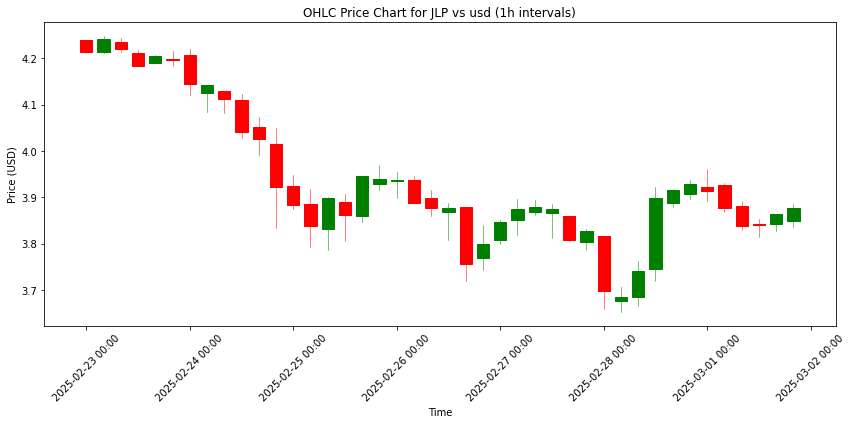

In [7]:
# Print and plot first price bar
if price_bars:
    first_token = price_bars[1]
    print(f"\nPrice bar for first token ({first_token.token_symbol} vs {first_token.base_token}):")
    print(first_token.data.tail())

    plot_data = first_token.data[["timestamp", "open", "high", "low", "close"]].copy()
    plot_data["timestamp"] = pd.to_datetime(plot_data["timestamp"])
    plot_data["timestamp"] = plot_data["timestamp"].map(pd.Timestamp.to_pydatetime).map(mpl_dates.date2num)

    fig, ax = plt.subplots(figsize=(12, 6))
    candlestick_ohlc(ax, plot_data.values, width=0.12, colorup='g', colordown='r')
    ax.xaxis.set_major_formatter(DateFormatter("%Y-%m-%d %H:%M"))
    plt.title(f"OHLC Price Chart for {first_token.token_symbol} vs usd (1h intervals)")
    plt.xlabel("Time")
    plt.ylabel("Price (USD)")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
else:
    print("No price bars fetched")

# USE ALREADY FETCHED PRICE DATA

In [8]:
import sys
import os
import pandas as pd
import glob

project_root = os.path.abspath(os.path.join(os.getcwd()))
sys.path.append(project_root)

from src.models.price_bar import PriceBar
from src.utils.analyzer import Analyzer

# Directory containing pickle files
output_dir = os.path.join(project_root, "price_data_1")
print(f"Reading pickle files from: {output_dir}")

# Fetch all .pkl files
pickle_files = glob.glob(os.path.join(output_dir, "*.pkl"))
print(f"Found {len(pickle_files)} pickle files: {[os.path.basename(f) for f in pickle_files]}")

Reading pickle files from: /Users/nicolaschiavo/Dev/internship/dex_analyzer/price_data_1
Found 28 pickle files: ['SOL-USD.pkl', 'GRPH-USD.pkl', 'MELANIA-USD.pkl', 'GIGA-SOL.pkl', 'JUPSOL-USD.pkl', 'FARTCOIN-USD.pkl', 'ASKJ-USD.pkl', 'JITOSOL-USD.pkl', 'KMNO-SOL.pkl', 'ARC-USD.pkl', 'JUPSOL-SOL.pkl', 'GIGA-USD.pkl', 'KMNO-USD.pkl', 'BSOL-USD.pkl', 'FWOG-SOL.pkl', 'LISTEN-USD.pkl', 'BONK-USD.pkl', 'JUP-USD.pkl', 'LUMO-USD.pkl', 'WBTC-USD.pkl', 'FWOG-USD.pkl', 'INF-USD.pkl', 'BSOL-SOL.pkl', 'TRUMP-USD.pkl', 'MSOL-USD.pkl', 'ANON-USD.pkl', 'CBBTC-USD.pkl', 'JLP-USD.pkl']


## CALCULATE CORRELATION MATRIX

In [9]:
import os
from src.utils.analyzer import Analyzer

# Define the directory containing your pickle files
pickle_dir = os.path.join(project_root, "price_data_1")

# Collect a list of all .pkl file paths
pickle_files = [
    os.path.join(pickle_dir, fname)
    for fname in os.listdir(pickle_dir)
    if fname.endswith(".pkl")
]

# Compute the correlation matrix directly from the pickle files.
corr_matrix = Analyzer.compute_correlation_matrix_from_pickle(pickle_files)

print("Correlation Matrix:")
display(corr_matrix)

Correlation matrix based on 20 overlapping timestamps
Correlation Matrix:


,SOL,GRPH,MELANIA,GIGA,JUPSOL,FARTCOIN,ASKJ,JITOSOL,KMNO,ARC,...,LUMO,WBTC,FWOG,INF,BSOL,TRUMP,MSOL,ANON,CBBTC,JLP
SOL,1.000000,0.267897,-0.063585,0.232153,0.211877,0.659955,0.719725,0.192831,0.000979,0.754325,...,0.305441,-0.157236,1.000000,0.202984,0.189304,0.162836,0.211919,0.855882,-0.126082,0.151931
GRPH,0.267897,1.000000,0.916187,0.960502,0.960223,0.718475,0.728752,0.950357,0.928847,0.547639,...,0.922079,0.835568,0.267897,0.954666,0.949143,0.967148,0.959248,0.148323,0.859520,0.942272
MELANIA,-0.063585,0.916187,1.000000,0.921892,0.930959,0.486969,0.486598,0.933739,0.984222,0.280622,...,0.838011,0.953264,-0.063585,0.932104,0.932258,0.956502,0.930287,-0.130696,0.961898,0.944772
GIGA,0.232153,0.960502,0.921892,1.000000,0.992634,0.631786,0.728572,0.990664,0.944183,0.530542,...,0.917864,0.891882,0.232153,0.991029,0.987786,0.960128,0.991554,0.175116,0.904972,0.991809
JUPSOL,0.211877,0.960223,0.930959,0.992634,1.000000,0.652043,0.728935,0.998776,0.949223,0.530701,...,0.913212,0.889280,0.211877,0.999188,0.996835,0.973841,0.997685,0.140974,0.902776,0.993490
FARTCOIN,0.659955,0.718475,0.486969,0.631786,0.652043,1.000000,0.901670,0.636162,0.506692,0.839757,...,0.695618,0.319218,0.659955,0.651642,0.623973,0.682821,0.640144,0.428827,0.355723,0.583673
ASKJ,0.719725,0.728752,0.486598,0.728572,0.728935,0.901670,1.000000,0.715306,0.534067,0.934879,...,0.718954,0.377538,0.719725,0.727193,0.702356,0.687528,0.719278,0.593509,0.404924,0.674982
JITOSOL,0.192831,0.950357,0.933739,0.990664,0.998776,0.636162,0.715306,1.000000,0.949638,0.517113,...,0.904689,0.895338,0.192831,0.999308,0.997845,0.972682,0.997849,0.130854,0.907164,0.995643
KMNO,0.000979,0.928847,0.984222,0.944183,0.949223,0.506692,0.534067,0.949638,1.000000,0.341164,...,0.865923,0.962554,0.000979,0.947734,0.947063,0.946343,0.945382,-0.073915,0.972829,0.962574
ARC,0.754325,0.547639,0.280622,0.530542,0.530701,0.839757,0.934879,0.517113,0.341164,1.000000,...,0.478962,0.150159,0.754325,0.529955,0.500382,0.490966,0.522469,0.650751,0.180701,0.476434


## CALCULATE BETA TO SOL

In [ ]:

pickle_dir = os.path.join(project_root, "price_data_1")

sol_pickle = os.path.join(pickle_dir, "SOL-USD.pkl")

token_pickle_files = [
    os.path.join(pickle_dir, fname)
    for fname in os.listdir(pickle_dir)
    if fname.endswith(".pkl") 
]

# Compute beta for each token with respect to SOL
beta_results = Analyzer.compute_beta_with_sol(sol_pickle, token_pickle_files)

print("Beta values (relative to SOL):")
for token, beta in beta_results.items():
    print(f"{token}: {beta}")

Beta values (relative to SOL):
SOL: 1.0000000000000002
GRPH: 0.22992007757818156
MELANIA: 0.12552877346010594
GIGA: 0.3505975394014772
JUPSOL: 0.12278708131887268
FARTCOIN: 0.31639036993762454
ASKJ: 0.5282619105817288
JITOSOL: 0.2451762008957929
KMNO: 0.15306687287493037
ARC: 0.41489608605596545
BSOL: 0.11224100504423438
FWOG: 1.0000000000000002
LISTEN: 0.23375280042458868
BONK: 0.23268065538015784
JUP: 0.18723110045335373
LUMO: 0.529323431831753
WBTC: 0.10019814633783598
INF: 0.22497162674553564
TRUMP: 0.14800236886644005
MSOL: 0.23227937692057565
ANON: 0.38559873378557546
CBBTC: 0.09269948196656838
JLP: 0.10987811491533303
